In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.eval import calculate_rouge

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/debatesum/test.csv")

scores3 = np.fromfile("results/checkpoint-1500_debatesum_scores")
with open("results/checkpoint-1500_debatesum_sentences") as file:
    texts3 = [line.rstrip() for line in file]

In [3]:
metric3 = list[float]()
for pred, label in zip(texts3, df["target"]):
    rouge = calculate_rouge(predictions=[pred], references=[[label]])["rougeL"]
    metric3.append(rouge)

In [4]:
df_score = pd.DataFrame(
    {
        "rougel_3": metric3,
        "cert_3": scores3,
    }
)

In [9]:
np.corrcoef(df_score["rougel_3"], df_score["cert_3"])

array([[1.        , 0.62785068],
       [0.62785068, 1.        ]])

Text(0, 0.5, 'RougeLSum')

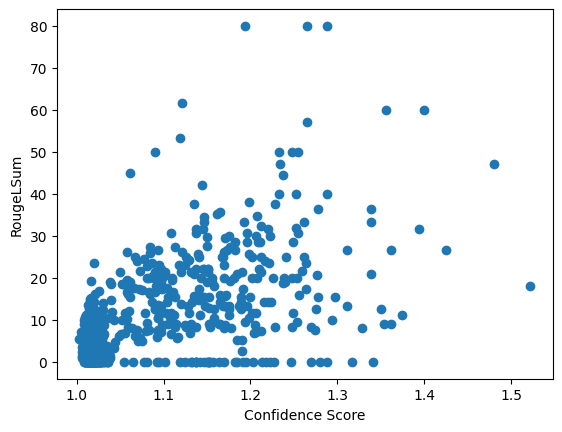

In [10]:
plt.scatter(y=df_score["rougel_3"], x=df_score["cert_3"])
plt.xlabel("Confidence Score")
plt.ylabel("RougeLSum")

In [ ]:
# Implement this
- read some of the outputs; are 0 rouge actually bad? what's going on here
- Need to use human judgement as a judge
    - read up on how to properly evaluate

- why is this interesting

- exp(a - b)
- Chat with Ori about predicting the difficulty of samples
- Try different values
- Reread KNIFE to see if this is doing a cheaper version of that
- Sample a bunch of points from the decoder, fit a gaussian, then figure out its entropy
- Or we might find that we should be more principled/KNIFE is better

- Archer Yi Yang – chat! Maybe the classification problem